## Digital approach to solving a QUBO: using QAOA and Linear Entanglement Ansatz.

In [27]:
from aquapointer.digital.qubo import Qubo
from aquapointer.digital.vqe import VQE
from aquapointer.digital.qubo_utils import get_ising_hamiltonian
from aquapointer.digital.ansatz import QAOA_ansatz
from aquapointer.density_canvas.DensityCanvas import DensityCanvas

# General imports
import numpy as np
import pickle
from pathlib import Path

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit.primitives import BackendSampler
from qiskit import transpile 
from qiskit_aer import AerSimulator

First we need some helper functions to load all the 3D RISM slices of some protein and (scaled) register positions of the corresponding QPU. Then we use Qubo to compute the corresponding QUBO matrices and Ising Hamiltonians.

In [28]:
BASE_PATH = str(Path.cwd().parent)
DENS_DIR = "/data/MUP1/MUP1_logfilter8_slices/"
PP_DIR = "/data/MUP1/MUP1_logfilter8_points/"
REG_DIR = "/registers/"

def load_density_slices(path: str) -> list[np.ndarray]:
    r"""The 3D-RISM density slices are saved as pickled files in the folder MUP1.
    They are indexed by a number (see d_list) which represents the distance in Angstrom
    from the central slice. This function loads the files.

    Args:
        path: Path to 3D-RISM density slices files.

    Returns:
        List of numpy arrays containing the slices.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "_density_slice_MUP1_logfilter8.p"
    densities = []
    for d in d_list:
        filename = path + f"d{d}" + basename
        with open(filename, 'rb') as file_in:
            densities.append(pickle.load(file_in))
            
    return densities


def load_plane_points(path: str) -> list[np.ndarray]:
    r"""Load slice coordinates (these are 3D coordinates in
    angstroms, they are needed at the very end to map
    excited qubits to positions in the protein cavity).

    Args:
        path: Path to plane points files.
    
    Returns:
        List of numpy arrays containing the plane points.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "_plane_points_MUP1.p"
    points = []
    for d in d_list:
        filename = path + f"d{d}" + basename
        with open(filename, 'rb') as file_in:
            points.append(pickle.load(file_in))
    
    return points

def load_register_positions(path: str) -> list[np.ndarray]:
    r"""The register associated to each slice can be found in the folder nb/registers.
    - position_<#>.npy: the positions of the qubits in micrometers, as if they were in the QPU

    Args:
        path: Path to register positions files.

    Returns:
        List of numpy arrays containing the register positions.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "position_"
    positions = []
    for i in range(len(d_list)):
        filename = path + basename + f"{i}.npy"
        with open(filename, 'rb') as file_in:
            pos = np.load(file_in)
        positions.append(pos)
    
    return positions

def load_rescaled_register_positions(path: str) -> list[np.ndarray]:
    r"""The register associated to each slice can be found in the folder nb/registers.
    - rescaled_position_<#>.npy: the positions of the qubits on the same scale as the density slices

    Args:
        path: Path to register positions files.

    Returns:
        List of numpy arrays containing the rescaled register positions.
    """
    d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    basename = "rescaled_position_"
    rescaled_positions = []
    for i in range(len(d_list)):
        filename = path + basename+f"{i}.npy"
        with open(filename, 'rb') as file_in:
            res_pos = np.load(file_in)
        rescaled_positions.append(res_pos)
    
    return rescaled_positions

In [29]:
# First we load the density files and rescaled register positions.
densities = load_density_slices(path=BASE_PATH + DENS_DIR)
rescaled_register_positions = load_rescaled_register_positions(path=BASE_PATH + REG_DIR)

# Qubo computes all the qubo matrices given the 3d rism 
# files and rescaled positions of registers from LoadData.
q = Qubo(densities, rescaled_register_positions)

We pick one QUBO matrix Ising Hamiltonian from the Qubo object and use that to define the ansatzes.

In [30]:
# Use the first slice as an example to solve.
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

# Print the qubo matrix.
qubo, qubo.shape

(array([[-0.01074377,  0.04727714,  0.04727714,  0.04727714],
        [ 0.04727714, -0.00892812,  0.03218907,  0.04727714],
        [ 0.04727714,  0.03218907, -0.00865155,  0.04727714],
        [ 0.04727714,  0.04727714,  0.04727714, -0.00969204]]),
 (4, 4))

Qubo object also has a function that computes the optimal bitstring and corresponding energy using classical brute-force approach.

In [13]:
# classical brute-force solution
solution = q.find_optimum(qubo=qubo)
solution

('1000', -0.010743767178636635)

For illustration, here is a drawing of the Linear Entanglement ansatz.

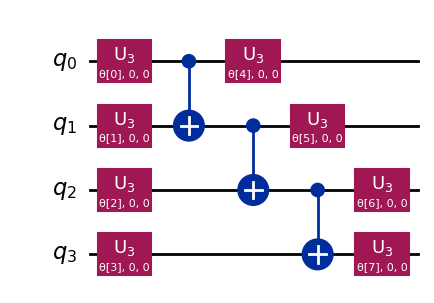

In [14]:
# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

# Drawing of the Linear Entanglement ansatz circuit.
basis_gates=['u1', 'u2', 'u3', 'cx']
ansatz_transpiled = transpile(le_ansatz, AerSimulator(), basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
ansatz_transpiled.draw('mpl', style='iqp')

Now that we have defined the qubo and ansatzes to be used, we use the VQE module to apply the variational approach. VQE accepts a qubo matrix, an ansatz, a sampler and initial parameters.

In [15]:
# EXAMPLE: QAQA

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# QAOA ansatz circuit.
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

alpha = 0.5 # confidence level for CVaR

# Initial parameters for the QAOA ansatz.
beta  = [0.7977]
gamma = [0.0765]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

# Run the minimization.
vqe_qaoa.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_qaoa.history

[['1000', 0.0603, -0.010743767178636635],
 ['1000', 0.0638, -0.010743767178636635],
 ['1000', 0.0673, -0.010743767178636635],
 ['1000', 0.084, -0.010743767178636635],
 ['1000', 0.044, -0.010743767178636635],
 ['1000', 0.0682, -0.010743767178636635],
 ['1000', 0.0911, -0.010743767178636635],
 ['1000', 0.0742, -0.010743767178636635],
 ['1000', 0.079, -0.010743767178636635],
 ['1000', 0.0805, -0.010743767178636635]]

In [23]:
# EXAMPLE: LE
np.random.seed(1)

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

alpha = 0.5 # confidence level for CVaR

params_le = np.array([np.random.random()]*le_ansatz.num_parameters)
vqe_le = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_le, prob_opt_sol=True)

# Now run the minimization procedure.
vqe_le.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_le.history

[['1000', 0.0395, -0.010743767178636635],
 ['1000', 0.0043, -0.010743767178636635],
 ['1000', 0.1616, -0.010743767178636635],
 ['1000', 0.1315, -0.010743767178636635],
 ['1000', 0.1245, -0.010743767178636635],
 ['1000', 0.0041, -0.010743767178636635],
 ['1000', 0.1896, -0.010743767178636635],
 ['1000', 0.156, -0.010743767178636635],
 ['1000', 0.1628, -0.010743767178636635],
 ['1000', 0.007, -0.010743767178636635]]

QAOA with warmstart.

In [24]:
# EXAMPLE: QAQA with warm start
np.random.seed(1)

qaoa_ansatz = QAOA_ansatz(qubo=qubo)

alpha = 0.7
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

vqe_qaoa.run(alpha=alpha, maxiter=10)
vqe_qaoa.history

[['1000', 0.0703, -0.010743767178636635],
 ['1000', 0.8098, -0.010743767178636635],
 ['1000', 0.8125, -0.010743767178636635],
 ['1000', 0.0003, -0.010743767178636635],
 ['1000', 0.0971, -0.010743767178636635],
 ['1000', 0.9981, -0.010743767178636635],
 ['1000', 0.8139, -0.010743767178636635],
 ['1000', 0.8588, -0.010743767178636635],
 ['1000', 0.8153, -0.010743767178636635],
 ['1000', 0.8223, -0.010743767178636635]]

The QUBO we solved is from a 3D RISM file. If you want to solve an arbitrary QUBO, we can do that as well.

In [18]:
# Define the QUBO matrix that you want to solve. Here we use a random symmetric matrix.

np.random.seed(3)
n = 4  # Size of the matrix
random_matrix = np.random.uniform(-0.5, 0.5, size=(n, n))
Q = (random_matrix + random_matrix.T)/2


# Now, the workflow is the same as above: define your favorite ansatz and minimize.
num_qubits = len(Q)
ham = get_ising_hamiltonian(Q)

# QAOA ansatz circuit.
qaoa_ansatz = QAOAAnsatz(ham, reps=1)

alpha = 0.5 # confidence level for CVaR

# Initial parameters for the QAOA ansatz.
beta  = [0.7977]
gamma = [0.0765]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=Q, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

# Run the minimization.
vqe_qaoa.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_qaoa.history

[['1010', 0.0676, -1.0769539443330833],
 ['1010', 0.0454, -1.0769539443330833],
 ['1010', 0.1396, -1.0769539443330833],
 ['1010', 0.0668, -1.0769539443330833],
 ['1010', 0.1855, -1.0769539443330833],
 ['1010', 0.018, -1.0769539443330833],
 ['1010', 0.2078, -1.0769539443330833],
 ['1010', 0.1046, -1.0769539443330833],
 ['1010', 0.12, -1.0769539443330833],
 ['1010', 0.2307, -1.0769539443330833]]

In [25]:
# Solve all the qubos for MUP1 protein

bitstring_solutions = []

for qubo, ising_ham in q.qubo_hamiltonian_pairs:
    num_qubits = len(qubo)
    np.random.seed(1)

    qaoa_ansatz = QAOA_ansatz(qubo=qubo)

    alpha = 0.7
    beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
    gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
    params = np.array(beta+gamma)
    vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

    vqe_qaoa.run(alpha=alpha, maxiter=10)
    bitstring_solutions.append(vqe_qaoa.history[-1][0])

bitstring_solutions

['1000',
 '010000001',
 '00001000001000',
 '10000000100100',
 '0000010100000',
 '00010000']